In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score

In [3]:
base_artifacts = Path.cwd().resolve().parents[1] / 'CausalI2I_artifacts'
raw_results = pd.read_csv(base_artifacts / 'Datasets' / 'Sequels' / 'sequels_evaluated.csv')

In [4]:
new_names = {
    'cosine_similarity': 'Cosine',
    'correlation': 'Pearson',
    'diff_of_conditionals': 'DoC',
    'jacard_index': 'Jaccard',
    'sasrec_score': 'SASRec'
}
raw_results = raw_results.rename(columns=new_names)

ate = raw_results['ATE'].values
std = raw_results['STD'].values

raw_results['STE'] = raw_results['ATE'] / raw_results['STD']
raw_results['ABLT/STD'] = raw_results['ABLT'] / raw_results['STD_ABLT']

baselines = ["ATE", "STE", "ABLT", "ABLT/STD", "Cosine", "Pearson", "DoC", "Jaccard", "SASRec"]

In [5]:
Ks = [10, 20, 50, 100, 200, 500, 1000]

vals2plot = {col: None for col in baselines}
for col in baselines:
    col_choises = raw_results.sort_values(by=col, ascending=False)['causal_link'].values
    vals2plot[col] = {K: np.sum(col_choises[:K]) for K in Ks}
total_positives = np.sum(raw_results['causal_link'].values)

summary = {}
for K in Ks:
    summary[('Precision@K (%)', f'K={K}')] = {
        col: 100 * vals2plot[col][K] / K
        for col in baselines}
for K in Ks:
    summary[('Recall@K (%)', f'K={K}')] = {
        col: 100 * vals2plot[col][K] / total_positives
        for col in baselines}
    
summary_df = pd.DataFrame(summary).map(lambda x: f'{x:.2f}')
summary_df

Precision@K (%)                                               \
                    K=10    K=20    K=50   K=100  K=200  K=500 K=1000   
ATE                70.00   75.00   88.00   89.00  89.00  85.80  83.60   
STE                90.00   95.00   94.00   95.00  97.00  96.40  91.20   
ABLT               80.00   75.00   84.00   88.00  86.50  88.40  87.00   
ABLT/STD          100.00  100.00  100.00  100.00  98.00  96.00  93.70   
Cosine             50.00   50.00   50.00   50.00  50.00  50.00  50.00   
Pearson            50.00   50.00   50.00   50.00  50.00  50.00  50.00   
DoC                 0.00   15.00   14.00   17.00  17.00  18.60  21.00   
Jaccard            50.00   50.00   50.00   50.00  50.00  50.00  50.00   
SASRec             60.00   55.00   48.00   52.00  42.50  40.20  40.30   

         Recall@K (%)                                        
                 K=10  K=20  K=50 K=100 K=200  K=500 K=1000  
ATE              0.19  0.41  1.20  2.43  4.85  11.69  22.78  
STE              0.25  0.52  1.28  2.59  5.29  13.13  24.85  
ABLT             0.22  0.41  1.14  2.40  4.71  12.04  23.71  
ABLT/STD         0.27  0.54  1.36  2.72  5.34  13.08  25.53  
Cosine           0.14  0.27  0.68  1.36  2.72   6.81  13.62  
Pearson          0.14  0.27  0.68  1.36  2.72   6.81  13.62  
DoC              0.00  0.08  0.19  0.46  0.93   2.53   5.72  
Jaccard          0.14  0.27  0.68  1.36  2.72   6.81  13.62  
SASRec           0.16  0.30  0.65  1.42  2.32   5.48  10.98

In [6]:
ap_results = {}
auc_results = {}

summary = {}
y_true = raw_results['causal_link'].values
for col in baselines:
    y_score = raw_results[col].values
    ap = average_precision_score(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)
    auc_results[col] = auc
    summary[col] = {'AP': ap, 'AUC': auc}

summary_df = pd.DataFrame(summary).map(lambda x: f'{x:.3f}').T
summary_df


,AP,AUC
ATE,0.746,0.754
STE,0.825,0.811
ABLT,0.766,0.765
ABLT/STD,0.835,0.812
Cosine,0.500,0.500
Pearson,0.500,0.500
DoC,0.389,0.336
Jaccard,0.500,0.500
SASRec,0.450,0.424


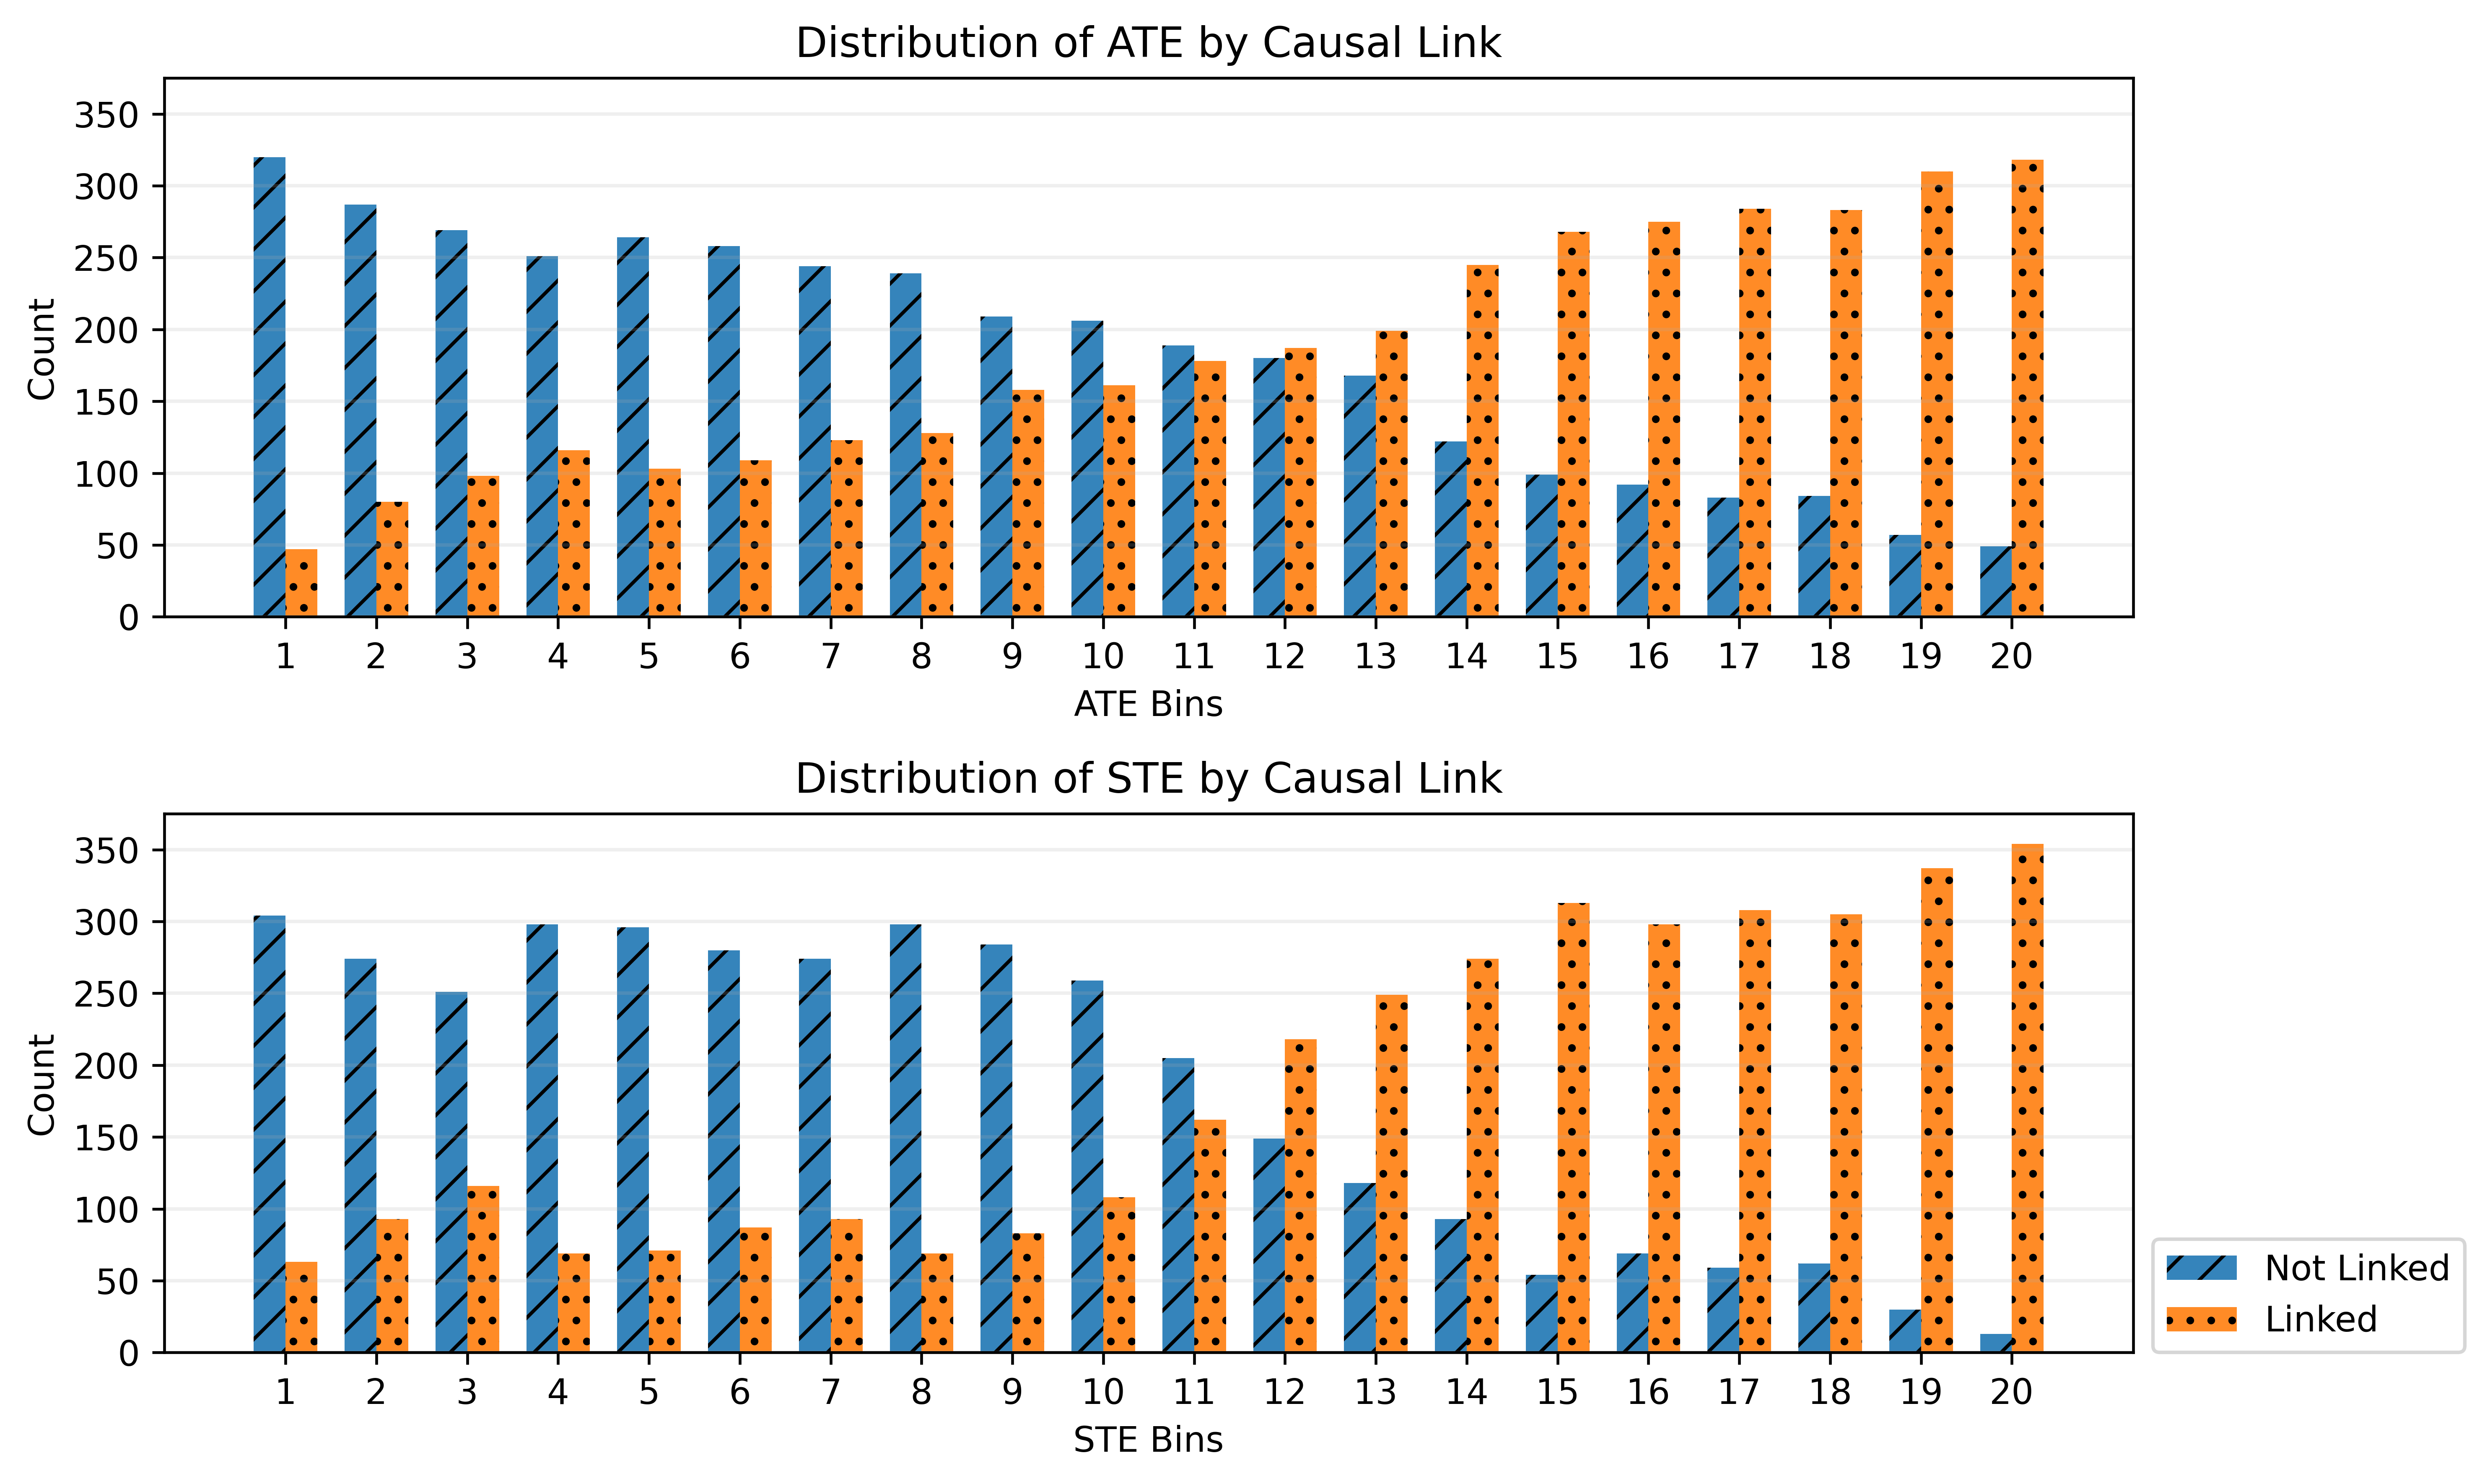

In [ ]:
num_bins = 20
w = 0.35
hatches = ['//', '..']

fig, axes = plt.subplots(2, 1, figsize=(10, 6), dpi=600)

for ax, metric in zip(axes, ["ATE", "STE"]):

    # Quantile bins for the current metric
    bins = np.quantile(
        raw_results[metric].values,
        np.arange(0, 1, 1 / num_bins)
    )

    df = raw_results[[metric, 'causal_link']].copy()
    df['metric_bin'] = np.digitize(df[metric], bins) - 1

    for link in [0, 1]:
        subset = df[df['causal_link'] == link]
        counts = subset['metric_bin'].value_counts().sort_index()

        ax.bar(
            counts.index + (link - 0.5) * w,
            counts.values,
            width=w,
            alpha=0.9,
            hatch=hatches[link],
            label='Linked' if link == 1 else 'Not Linked'
        )

    ax.set_xticks(range(num_bins))
    ax.set_xticklabels(range(1, num_bins + 1))
    ax.set_yticks(range(0, 351, 50))
    ax.set_ylim(0, 375)
    ax.set_xlabel(f'{metric} Bins')
    ax.set_ylabel('Count')
    ax.set_title(f'Distribution of {metric} by Causal Link')

    # ax.set_yscale('log')
    ax.grid(axis='y', which='major', alpha=0.2, linewidth=1)

plt.legend(loc=(1.01, 0))
plt.tight_layout()
plt.savefig(
    base_artifacts / 'Figures' / 'sequels' / 'Binned Precision.png',
    bbox_inches='tight')
plt.show()